# HOG介绍

## 简介

HOG特征即 Histogram of oriented gradients，源于2005年一篇CVPR论文，使用HOG+SVM做行人检测，由于效果良好而被广泛应用。

算法计算步骤概览
1. 图像预处理（可选），伽马矫正(减少光度影响)和灰度化(也可以在RGB图上做，只不过对三通道颜色值计算，取梯度值最大的)
2. 计算图像像素点梯度值，得到梯度图(尺寸和原图同等大小)
3. 图像划分多个cell，统计cell内梯度直方向方图
4. 将2×2个cell联合成一个block，对每个block做块内梯度归一化

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# 图像预处理

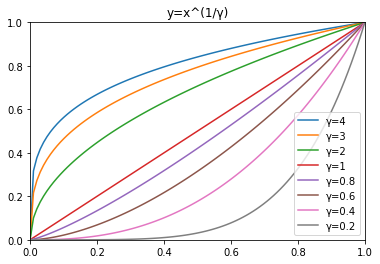

In [5]:
x = np.linspace(0, 1, 100)
N = 4
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
legends = []
for i in range(N, 1, -1):
    y = pow(x,(1.0/i))
    plt.plot(x, y)
    legends.append('γ={}'.format(i))
y=x
plt.plot(x, x)
legends.append('γ=1')

for i in np.arange(0.8, 0.2, -0.2):
    y = pow(x,(1.0/i))
    plt.plot(x, y)
    legends.append('γ={:.1}'.format(i))
plt.legend(legends)
# plt.legend(['γ=1/4', 'γ=1/3','γ=1/2', 'γ=1', 'γ=2','γ=3','γ=4'])
plt.title('y=x^(1/γ)')
plt.show()


gamma矫正通常用于电视和监视器系统中重现摄像机拍摄的画面．在图像处理中也可用于调节图像的对比度，减少图像的光照不均和局部阴影． 

**原理**： 通过非线性变换，让图像从暴光强度的线性响应变得更接近人眼感受的响应，即将漂白（相机曝光）或过暗（曝光不足）的图片，进行矫正。  
**gamma矫正公式**： $f(x)=x^\gamma$ 即输出是输入的幂函数，指数为$\gamma$

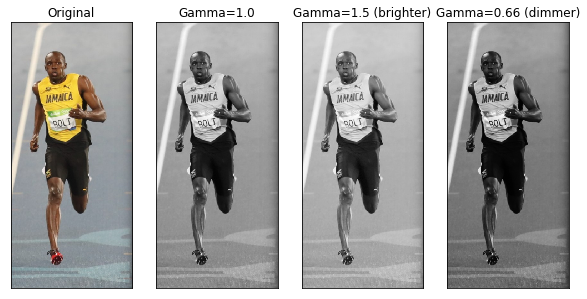

In [8]:
color_img = cv2.imread("Bolt.png")
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
light_img = np.power(gray_img/float(np.max(gray_img)), 1/1.5)
dark_img = np.power(gray_img/float(np.max(gray_img)), 1/0.66)

plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.xticks([]),plt.yticks([])
plt.imshow(color_img)
plt.title("Original")

plt.subplot(1,4,2)
plt.xticks([]),plt.yticks([])
plt.imshow(gray_img, cmap='gray')
plt.title("Gamma=1.0")

plt.subplot(1,4,3)
plt.xticks([]),plt.yticks([])
plt.imshow(light_img, cmap='gray')
plt.title("Gamma=1.5 (brighter)")

plt.subplot(1,4,4)
plt.xticks([]),plt.yticks([])
plt.imshow(dark_img, cmap='gray')
plt.title("Gamma=0.66 (dimmer)")

plt.show()

## 计算图像像素梯度图
我们需要用Sobel算子同时计算图像的水平梯度图和垂直梯度图 。

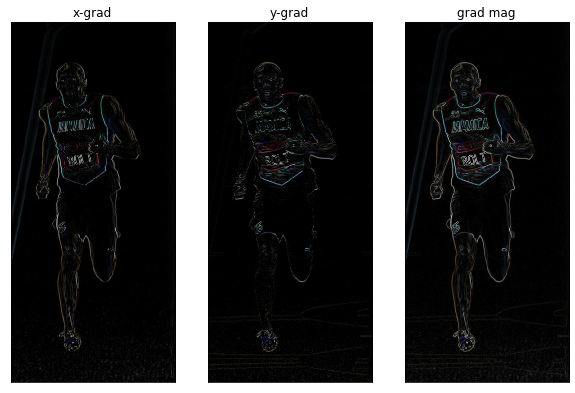

In [3]:
img = cv2.imread("Bolt.png")
img = np.float32(img) / 255.0

# 计算梯度
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

# 计算梯度幅度和方向
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

gx = np.abs(gx)
gy = np.abs(gy)
angle = np.abs(angle)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.xticks([]),plt.yticks([])
plt.imshow(gx, cmap='gray')
plt.title("x-grad")

plt.subplot(1,3,2)
plt.xticks([]),plt.yticks([])
plt.imshow(gy, cmap='gray')
plt.title("y-grad")

plt.subplot(1,3,3)
plt.xticks([]),plt.yticks([])
plt.imshow(mag, cmap='gray')
plt.title("grad mag")

plt.show()

可以看到
- x方向梯度图会强化垂直方向的特征，可以观察到左侧白色斜线更加明显，但是底部一些水平线没有了。
- y方向梯度图会强化水平方向特征，底部水平线强化了，左侧垂直线不是那么明显了。

## 计算梯度直方图
  经过上一步计算之后，每个像素点都会有两个值：梯度方向和梯度幅度。  
  但是，也看到了，梯度幅度和梯度方向图与原图等同大小，实际如果使用这些特征，会存在两个问题：
- 计算量很大，基本就是原图
- 特征稀疏。图中其实只有少量稀疏的显著特征，大部分可能是0  

HOG特征在此步骤选择联合一个8×8的小格子内部一些像素，计算其梯度幅度和梯度方向的统计直方图，这样一来就可以以这个梯度直方图来代替原本庞大的矩阵。每个像素有一个梯度幅度和梯度方向两个取值，那么一个8×8的小格子一共有8×8×2=128个取值。  
梯度方向取值范围是[0,180]，以每20°为一个单元，所有的梯度方向可以划分为9组，这就是统计直方图的分组数目。如下图，我们选取划分格子之后的第二行第二列一个小单元，计算得到右边的梯度方向图和梯度幅度图，同时以以梯度方向为index，统计分组数量。

![](hog1.jpg)

得到的统计频率直方图如下
![](hog2.jpg)

从上图可以看到，更多的点的梯度方向是倾向于0度和160度，也就是说这些点的梯度方向是向上或者向下，表明图像这个位置存在比较明显的横向边缘。因此HOG是对边角敏感的，由于这样的统计方法，也是对部分像素值变化不敏感的，所以能够适应不同的环境。  
至于为什么选取8×8为一个单元格，是因为HOG特征当初设计时是用来做行人检测的。在行人图片中8×8的矩阵被缩放成64×128的网格时，足以捕获一些特征，比如脸部或者头部特征等。

## Block归一化

**目的**：降低光照的影响  
**方法**：向量的每一个值除以向量的模长。  
HOG在选取8×8为一个单元格的基础之上，再以2×2个单元格为一组，称为block。作者提出要对block进行归一化，由于每个单元格cell有9个向量，2×2个单元格则有36个向量，需要对这36个向量进行归一化。下图演示了如何在图像中抽取block

![](hog3.gif)

## HOG特征描述
每一个16×16大小的block将会得到36大小的vector。那么对于一个64×128大小的图像，按照上图的方式提取block，将会有7个水平位置和15个竖直位可以取得，所以一共有7×15=105个block，所以我们整合所有block的vector，形成一个大的一维vector的大小将会是36×105=3780。

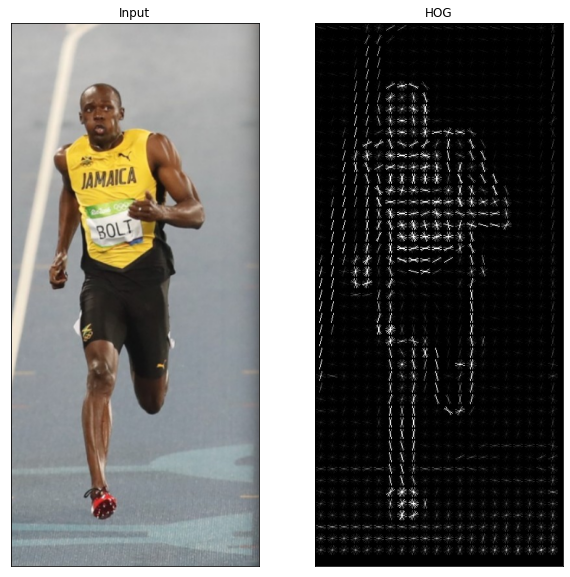

In [33]:
from skimage.feature import hog
from skimage import data, exposure
image = cv2.imread("Bolt.png")
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), 
                    visualize=True, multichannel=True, block_norm='L2-Hys')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.xticks([]),plt.yticks([])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Input")

plt.subplot(1,2,2)
plt.xticks([]),plt.yticks([])
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG")

plt.show()

In [73]:
import pdb

class Hog_descriptor():
    def __init__(self, img, cell_size, bin_size):
        self.img = img
        self.cell_size = int(cell_size)
        self.bin_size = int(bin_size)
        self.angle_unit = int(180 // self.bin_size)

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)
        
#         print(cell_gradient_vector)
        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude, gradient_angle = cv2.cartToPolar(gradient_values_x, gradient_values_y, angleInDegrees=True)
        gradient_angle = gradient_angle % 180
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
#                 orientation_centers[min_angle] += (gradient_strength )
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * np.sqrt(magnitude)))
                    angle += angle_gap
        return image

3772


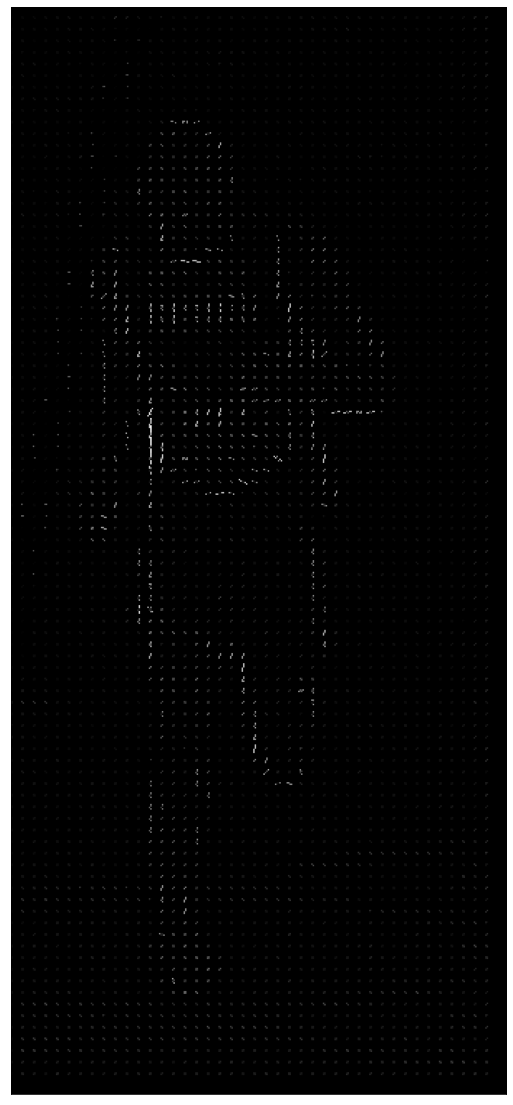

In [74]:
img = cv2.imread("Bolt.png", cv2.IMREAD_GRAYSCALE)
img = np.power(img/255., 1/1.5)*255
hog = Hog_descriptor(img, cell_size=8, bin_size=9)
vector, image = hog.extract()
print(len(vector))
plt.figure(figsize=(20, 20))
plt.xticks([]),plt.yticks([])
plt.imshow(image, cmap=plt.cm.gray)
plt.show()